## GROUP 135 PROJECT PROPOSAL

Group Members: Jannah Mohamed, Kate Saychaleun, Julia Toito, Elaine Chen


In [1]:
library(tidyverse)
library(readxl)
library(ggplot2)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
set.seed(2022)

download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls")

In [3]:
user_training_data <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Training_Data")%>%
    select(STG:UNS)

New names:
• `` -> `...7`
• `` -> `...8`


In [4]:
user_test_data <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", "Test_Data")%>%
    select(STG:UNS)                    

New names:
• `` -> `...7`
• `` -> `...8`


In [5]:
# tallying up the amount of each category of UNS 
tally <- user_training_data %>%
    group_by(UNS) %>%
    summarize(amount = n()) %>%
    arrange(c(4, 2, 3, 1))

# mean of each one of the predictor variable
means <- user_training_data %>%
    select(-UNS) %>%
    map_df(mean)

In [6]:
pvl1 <- user_training_data %>%
    ggplot(aes(x = STG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("STG (The Degree of Study Time for Goal Object Materials)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High")) +
    ggtitle("The Knowledge Level Of a User \nDepending on their Degree of Study Time for Goal Object Materials") +
    theme(text = element_text(size = 14))

pvl2 <- user_training_data %>%
    ggplot(aes(x = SCG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("SCG (The Degree of Repetition Number of User for Goal Object Materials)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High")) +
    ggtitle("The Knowledge Level Of a User \nDepending on their Degree of Repetition Number of User for Goal Object Materials") +
    theme(text = element_text(size = 14))

pvl3 <- user_training_data %>%
    ggplot(aes(x = STR, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("STR (The Degree of Study Time of User for Related Objects with Goal Object)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High")) +
    ggtitle("The Knowledge Level Of a User \nDepending on their Degree of Study Time of User for Related Objects with Goal Object")+
    theme(text = element_text(size = 14))

pvl4 <- user_training_data %>%
    ggplot(aes(x = LPR, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("LPR (The Exam Performance of User for Related Objects with Goal Object)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High")) +
    ggtitle("The Knowledge Level Of a User \nDepending on their Exam Performance of User for Related Objects with Goal Object") +
    theme(text = element_text(size = 14))

pvl5 <- user_training_data %>%
    ggplot(aes(x = PEG, y = UNS, fill = UNS)) +
    geom_boxplot() +
    ylab("UNS (The Knowledge Level Of User)") +
    xlab("PEG (The Exam Performance of User for Goal Objects)") +
    scale_y_discrete(limits = c("very_low", "Low", "Middle", "High")) +
    ggtitle("The Knowledge Level Of a User \nDepending on their Exam Performance of User for Goal Objects") +
    theme(text = element_text(size = 14))

In [7]:
# performing forward selection
names <- colnames(user_training_data |> select(-UNS))
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

cancer_vfold <- vfold_cv(user_training_data, v = 5, strata = UNS)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("UNS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        cancer_recipe <- recipe(as.formula(model_string), 
                                data = user_training_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(cancer_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = cancer_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [8]:
point <- user_training_data %>%
    ggplot(aes(x = PEG, y = LPR, color = as_factor(UNS))) +
    geom_point() +
    labs(x = "PEG (The Exam Performance of User for Goal Objects)", y = "LPR (The Exam Performance of User for Related Objects with Goal Object)", color = "UNS (The Knowledge Level Of User)")+
    ggtitle("The Exam Performance of User for Goal Objects \n Depending on The Exam Performance of User for Related Objects with Goal Object") +
    theme(text = element_text(size = 14))

## Introduction
#### **Which set of predictors accurately demonstrates one’s UNS: The Knowledge Level of a User?**
For our group project we will explore the development of intuitive knowledge classifiers and the modeling of domain dependent data. The dataset aims to classify the level of a user's knowledge on Electrical DC Machines, using an intuitive algorithmic classifier. 
First, the proposed knowledge classifier investigates the best weighted values for the students’ knowledge classes. Then, the distance between the students is calculated using their data and weight values. These differences in the classification procedure are then employed to define their knowledge class (very_low, Low, Middle, High). The model classifies them through weighting students’ domain-dependent data, a combination of user modeling algorithms and population-based approach. The approach enables us to optimize the accuracy score and visualize the relationship between the categories.

## Preliminary Exploratory Analysis

After importing and reading the dataset from the csv file, we will be using the “UNS (The knowledge level of user)” column as the target value.

## Graphs and Tables

This table shows how many observations each category (very_low, Low, Middle, High) of UNS user_training_data has. This gives us an idea of the weight distribution of each variable. If the model is more skewed towards one variable, we can shift the weight to accomodate for other variables accordingly.

In [9]:
tally

UNS,amount
<chr>,<int>
very_low,24
Low,83
Middle,88
High,63


This table shows the mean of each one of the potential predictor variables (STG, SCG, STR, LPR, PEG).

In [10]:
means

STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


**Pvl1**: There is mostly a positive correlation between the mean of study time and UNS, meaning students typically score higher the more time they spend on studying Goal Object Materials. However, there are some outliers in the model. For example, there is one student whose degree of study time is high but is still “very low” in UNS.

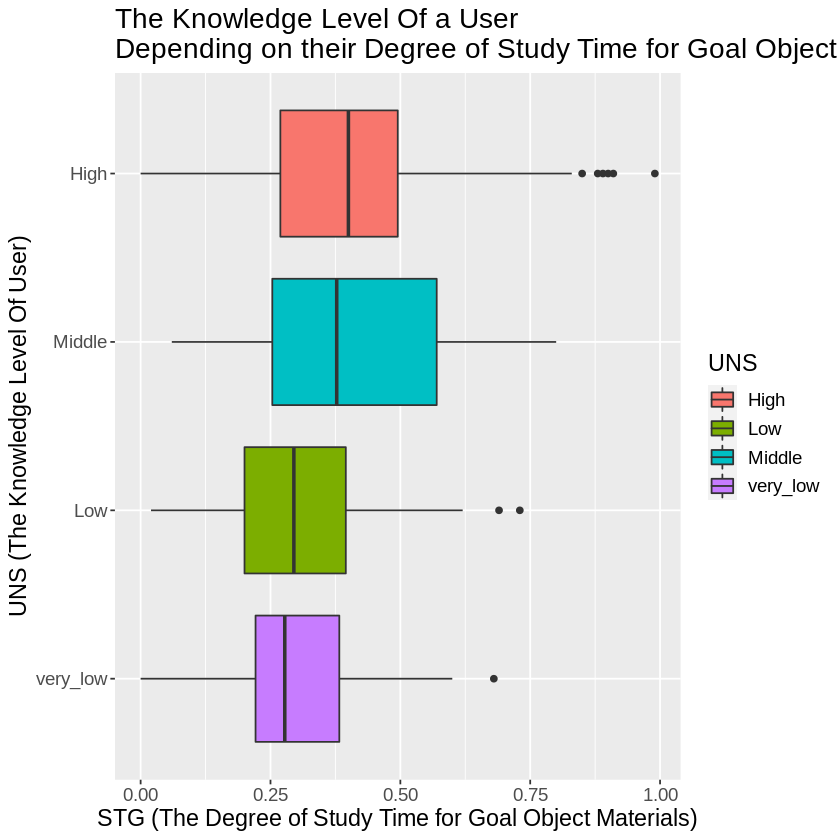

In [11]:
options(repr.plot.width = 7, repr.plot.height = 7)
pvl1

**Pvl2**: The relationship between the mean repetition and UNS is a positive trend, indicating that higher scores are more dependent on the student’s repetition in studying the Goal Object Materials. 

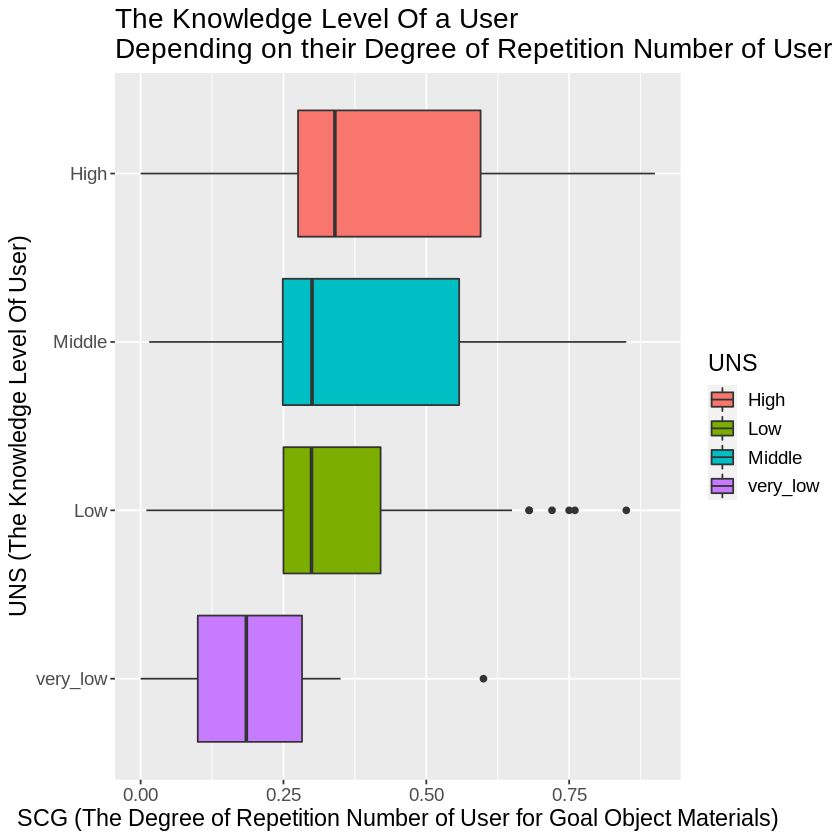

In [12]:
pvl2

**Pvl3**: There is no real relationship between UNS and STR.

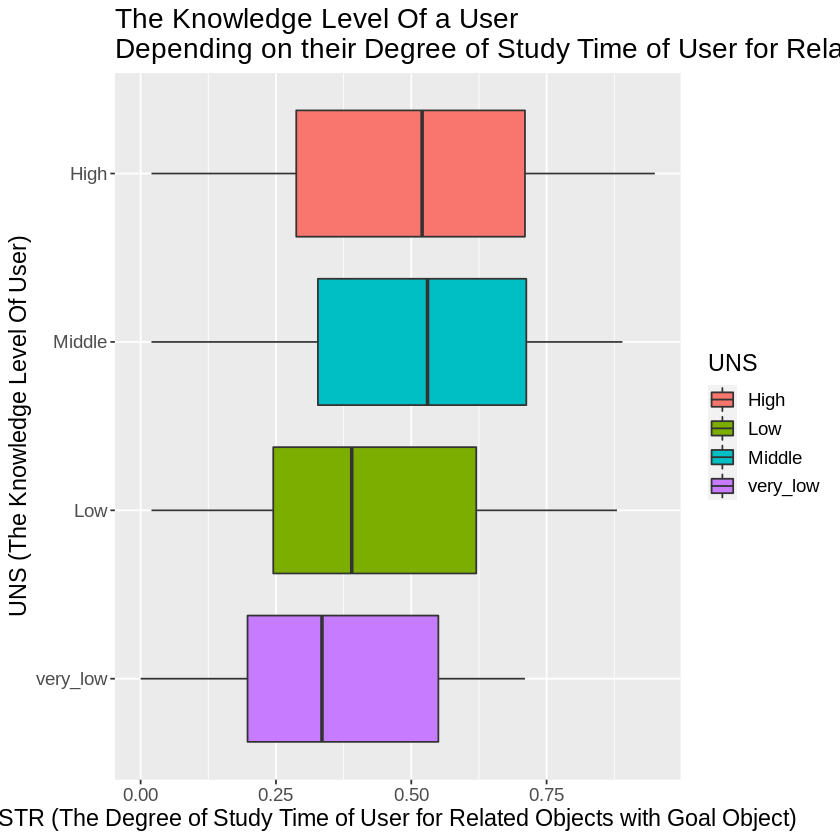

In [13]:
pvl3

**Pvl4**: There is no real relationship between UNS and LPR.

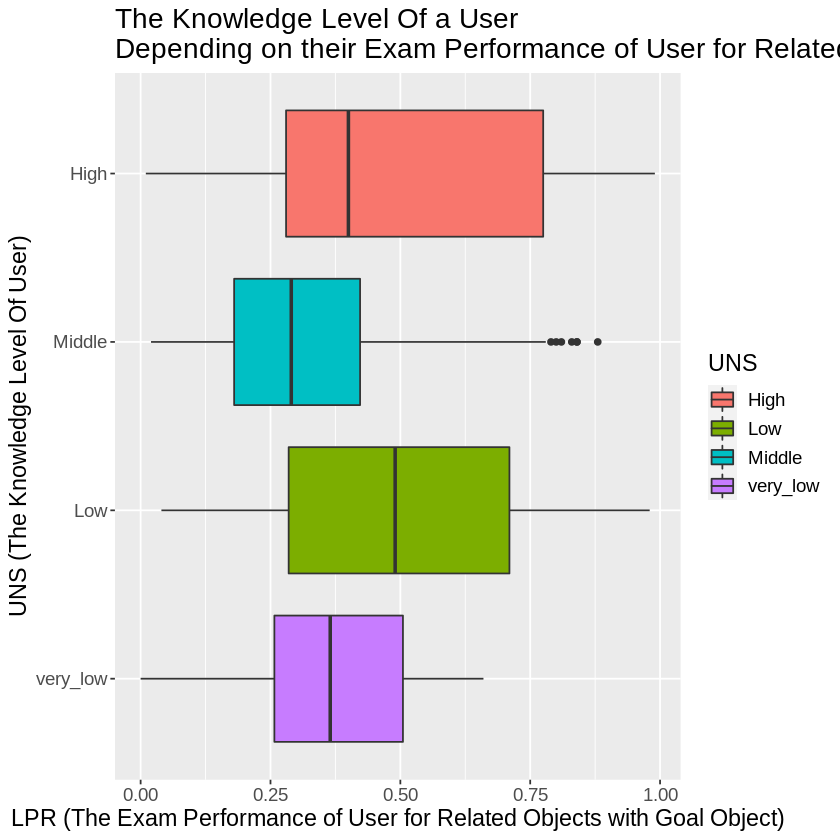

In [14]:
pvl4

**Pvl5**: There is a clear positive correlation between the mean of exam performance for Goal Objects and UNS. In other words, the dataset shows that the higher the student can score in their exam, the higher their level of UNS is. There are some outliers where the students scored less than the mean score, but have a higher level of UNS than the majority in their group.

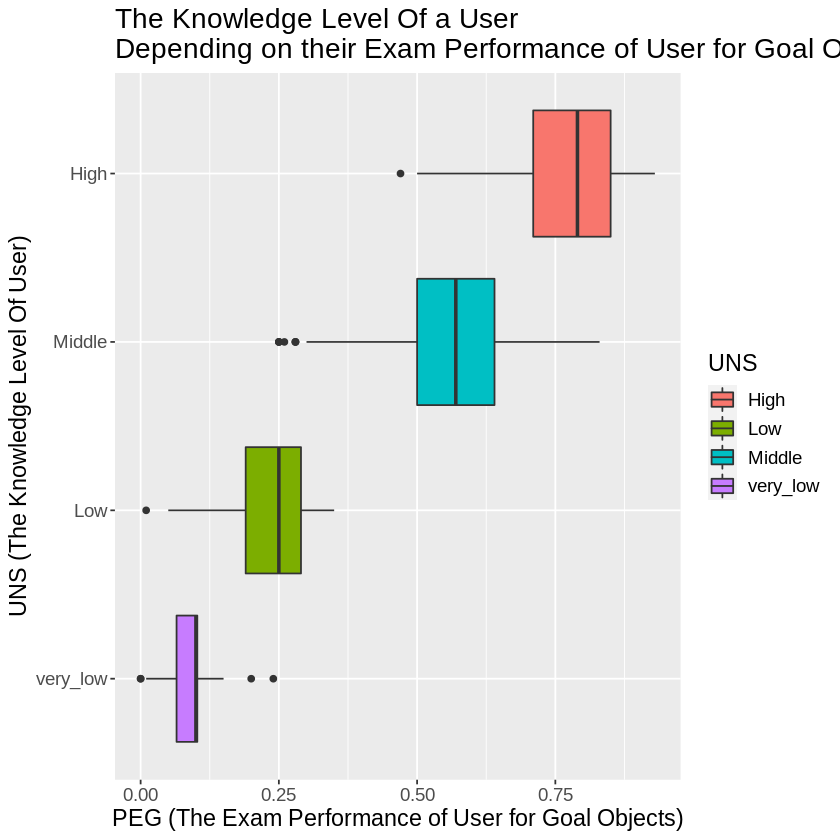

In [15]:
pvl5

**accuracies:** Using forward selection, test each combination of variables to find which ones are most suitable to use as predictors. As we can see in this table, the combination of PEG + LPR gives the highest estimated accuracy for predicting UNS; therefore it would be ideal to use the PEG and LPR as predictors.

In [16]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,UNS ~ PEG,0.8453474
2,UNS ~ PEG+LPR,0.9577533
3,UNS ~ PEG+LPR+SCG,0.9307463
4,UNS ~ PEG+LPR+SCG+STG,0.8527378
5,UNS ~ PEG+LPR+SCG+STG+STR,0.7754202


**Point:** The categories of UNS are clearly separated into different sections of the graph. We can see that as PEG gets larger, the UNS of the observations increase from very_low to Low to Middle to High.

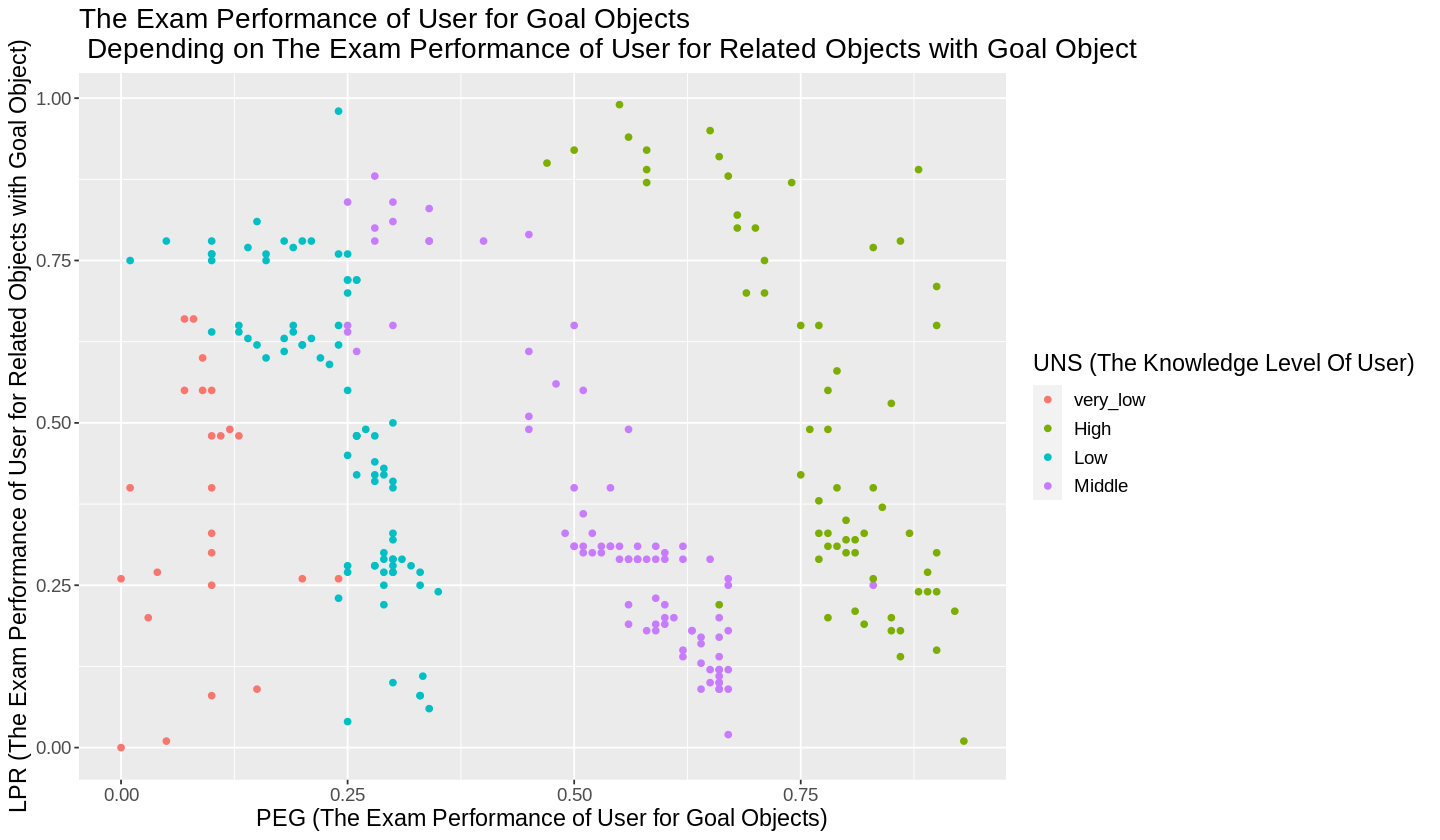

In [17]:
options(repr.plot.width = 12, repr.plot.height = 7)
point

## Method
Given the variable we are trying to predict (UNS), is categorical and not continuous, the correct model to employ would be a classification model. We are going to use the K-nearest neighbors classification model to try and predict UNS. The predictor variables we are going to use are PEG and LPR. This is because we used forward selection to try and see which combination of variables is most likely to be accurate for predicting UNS, and PEG + LPR had the highest estimated accuracy, at 0.96. We also graphs PEG against LPR and coloured the observations by UNS, to try and see if the observations are indeed separated into clear categories, which they are. 

In [18]:
set.seed(2022)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_recipe <- recipe(UNS ~ PEG + LPR, data = user_training_data)

vfold <- vfold_cv(user_training_data, v = 5, strata = UNS)

knn_fit <- workflow() |>
              add_recipe(knn_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = vfold, grid = 10) |>
              collect_metrics() |>
              filter(.metric == "accuracy")

knn_fit_graph <- ggplot(knn_fit, aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
                ggtitle("Plotting Accuracy Estimate against Neighbor K") +
                theme(text = element_text(size = 14))

In [19]:
accuracy <- knn_fit |>
    filter(neighbors == 3) |>
    select(mean)
accuracy

mean
<dbl>
0.9577505


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,multiclass,0.9577533,5,0.01386275,Preprocessor1_Model03
6,accuracy,multiclass,0.9577533,5,0.01386275,Preprocessor1_Model04
3,accuracy,multiclass,0.9577505,5,0.01371466,Preprocessor1_Model02
8,accuracy,multiclass,0.9462846,5,0.01818526,Preprocessor1_Model05
2,accuracy,multiclass,0.9424356,5,0.02053540,Preprocessor1_Model01
9,accuracy,multiclass,0.9345199,5,0.01959131,Preprocessor1_Model06
10,accuracy,multiclass,0.9345199,5,0.01959131,Preprocessor1_Model07
11,accuracy,multiclass,0.9308217,5,0.02200297,Preprocessor1_Model08
13,accuracy,multiclass,0.9152050,5,0.02438150,Preprocessor1_Model09


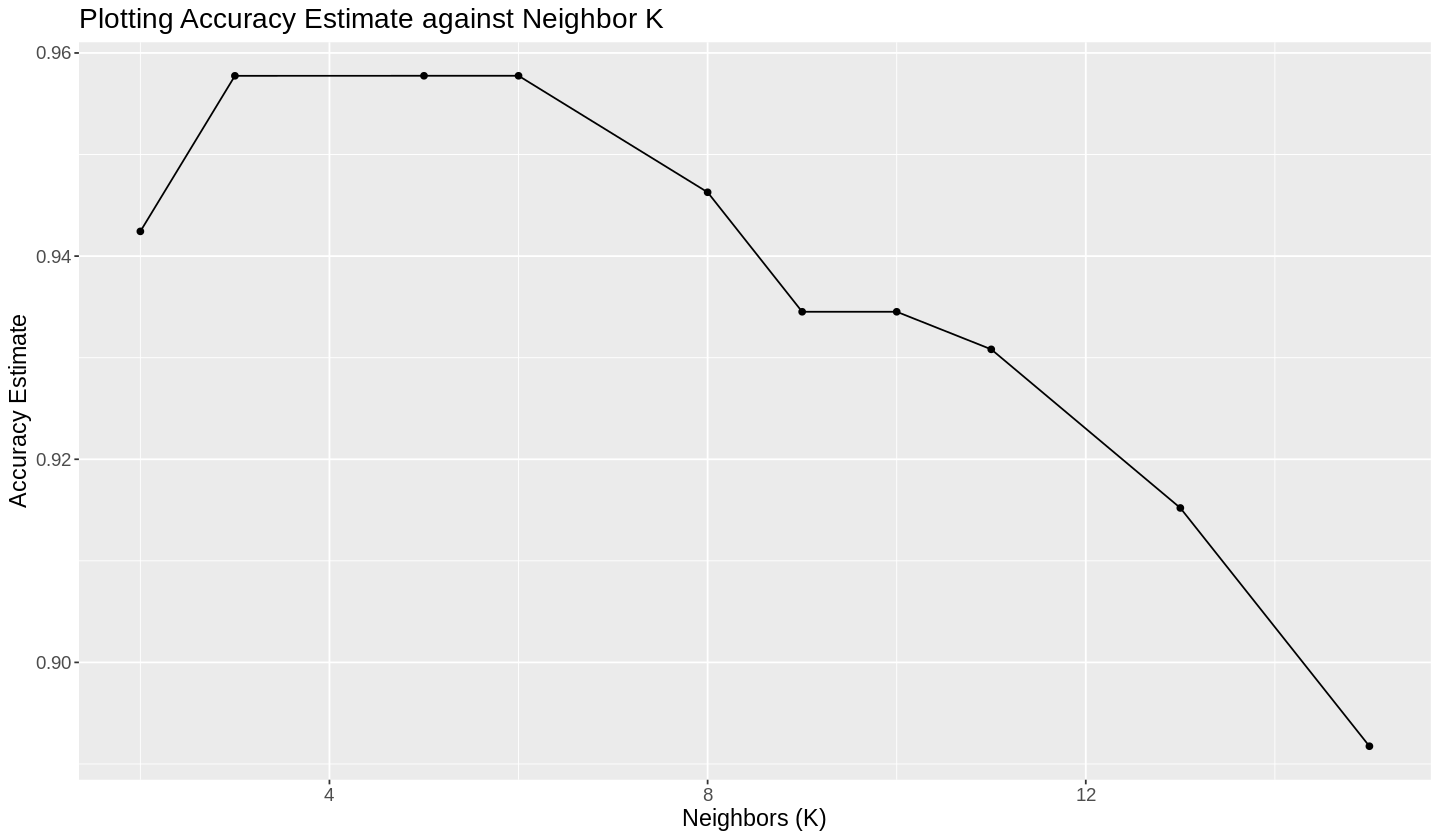

In [20]:
knn_fit_graph
knn_fit <- knn_fit %>%
    arrange(desc(mean))
knn_fit

In [21]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
      set_engine("kknn") |>
      set_mode("classification")

user_fit <- workflow() |>
              add_recipe(knn_recipe) |>
              add_model(knn_spec) |>
              fit(data = user_training_data)

class_prediction <- predict(user_fit, user_test_data) |>
              bind_cols(user_test_data)

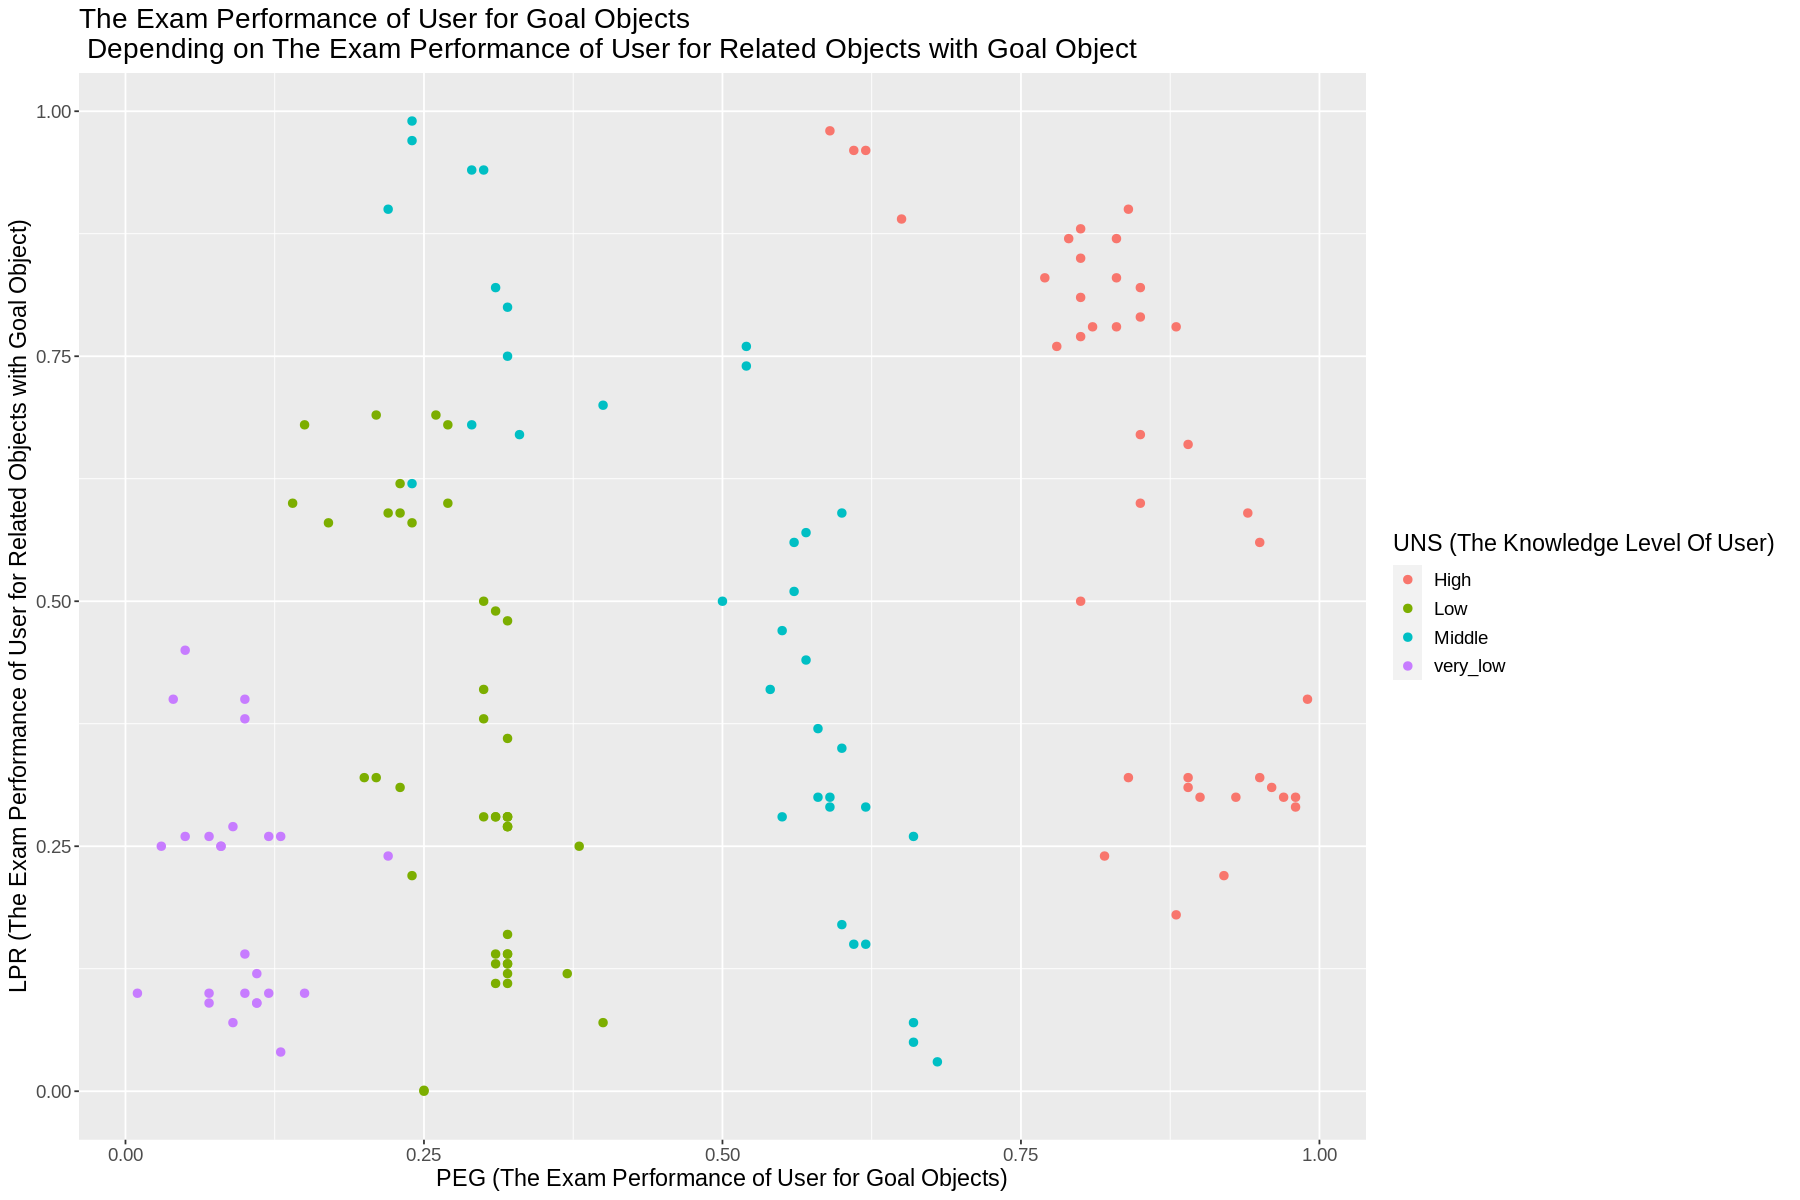

In [22]:
options(repr.plot.width = 15, repr.plot.height = 10)
class_plot <- ggplot(class_prediction, aes(x = PEG, y = LPR, color = as_factor(.pred_class))) +
            geom_point(size = 2) + 
            labs(x = "PEG (The Exam Performance of User for Goal Objects)", y = "LPR (The Exam Performance of User for Related Objects with Goal Object)", color = "UNS (The Knowledge Level Of User)")+
            ggtitle("The Exam Performance of User for Goal Objects \n Depending on The Exam Performance of User for Related Objects with Goal Object") +
            theme(text = element_text(size = 14))

class_plot

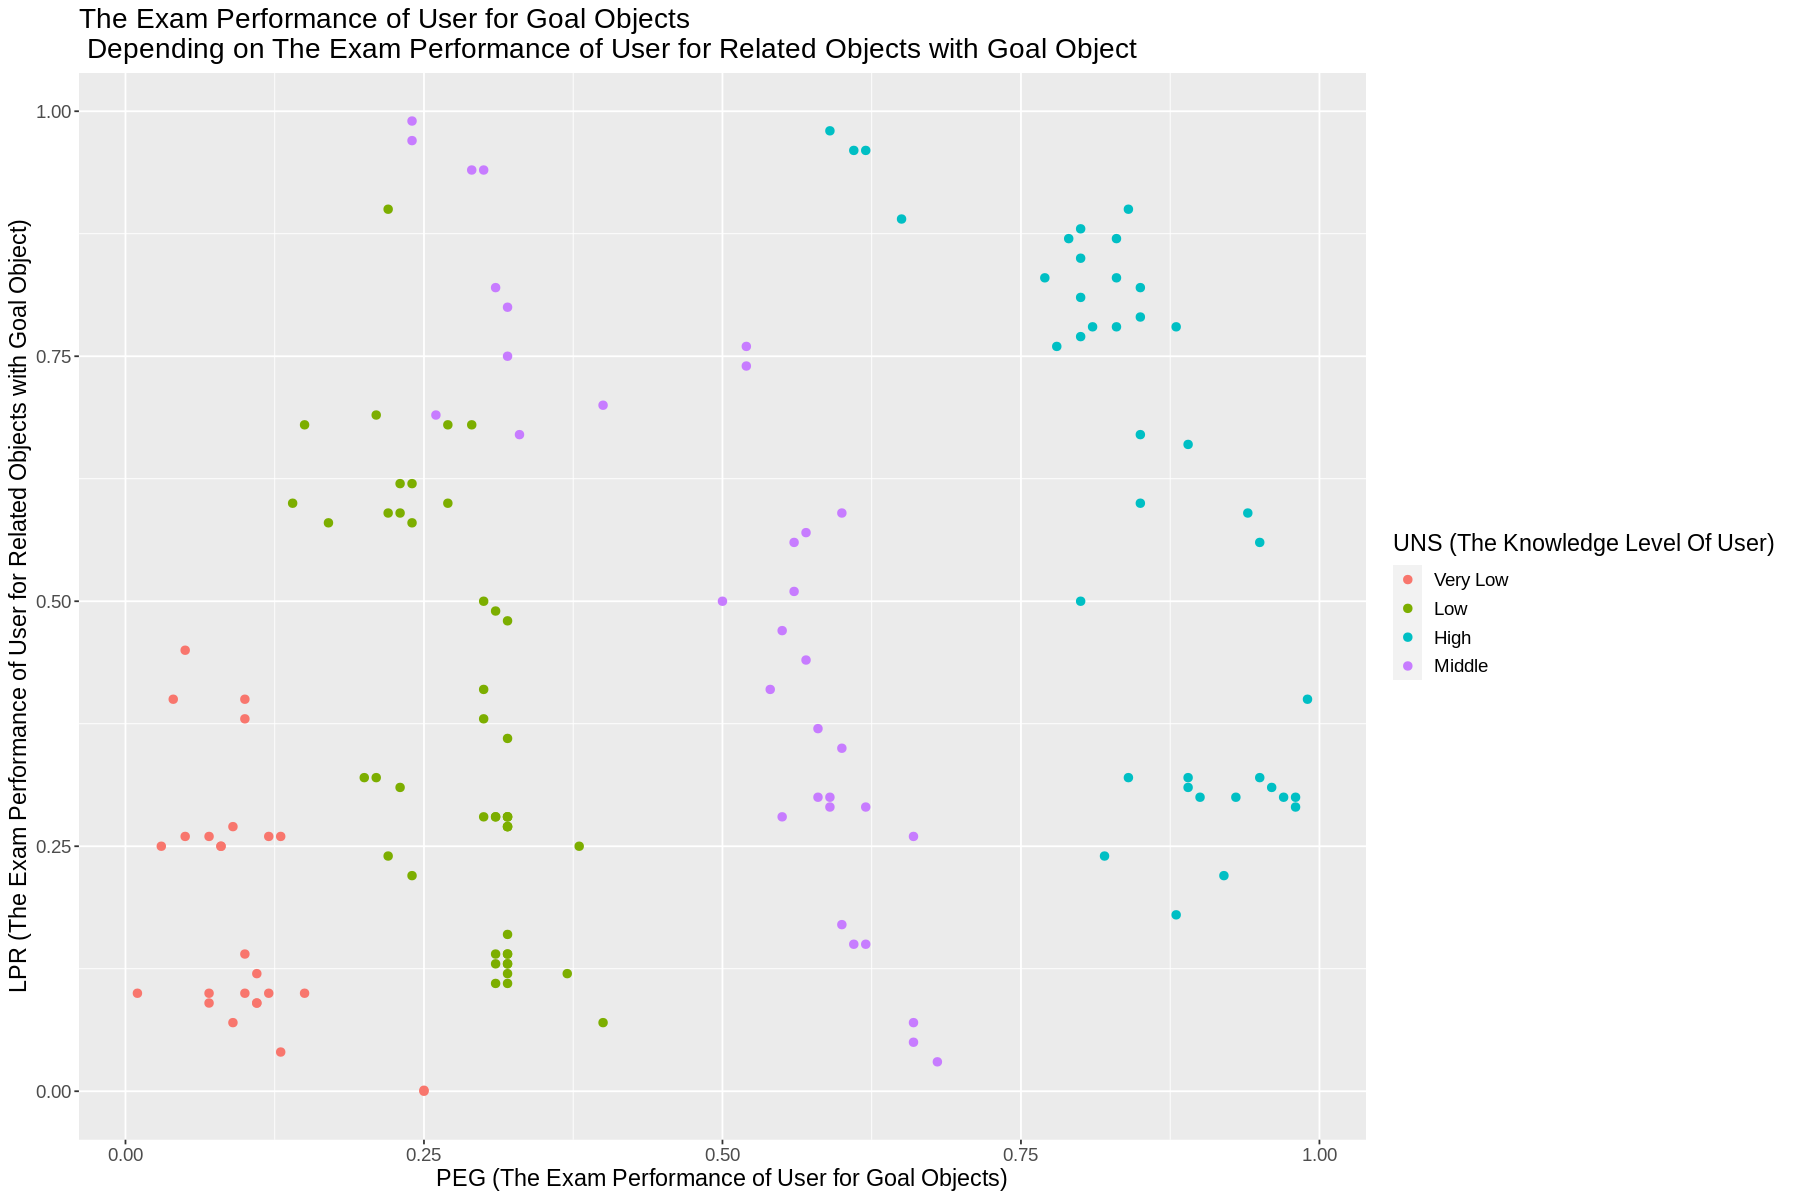

In [23]:
true_plot <- ggplot(class_prediction, aes(x = PEG, y = LPR, color = as_factor(UNS))) +
            geom_point(size = 2) + 
            labs(x = "PEG (The Exam Performance of User for Goal Objects)", y = "LPR (The Exam Performance of User for Related Objects with Goal Object)", color = "UNS (The Knowledge Level Of User)")+
            ggtitle("The Exam Performance of User for Goal Objects \n Depending on The Exam Performance of User for Related Objects with Goal Object") +
            theme(text = element_text(size = 14))

true_plot

In [24]:
# class_prediction <- names(class_prediction)[names(class_prediction) == "Very Low"] <- "very_low"
# names(mydat)[names(mydat) == "Yrs_From_Dx"] <- "Years_From_Diagnosis"

# class_prediction <- class_prediction
#     mutate(UNS = recode(UNS, Very Low = "very_low"))
# class_prediction
# class_prediction

In [25]:
# confusion <- class_prediction |>
#       mutate(UNS = as_factor(UNS)) |>
#       mutate(.pred_class = as_factor(.pred_class)) |>
#       conf_mat(truth = UNS, estimate = .pred_class)

ERROR: [1m[33mError[39m in [1m[1m`yardstick_table()`:[22m
[33m![39m `truth` and `estimate` must have the same levels in the same order.
[34mℹ[39m This is an internal error in the yardstick package, please report it to the package authors.


In [40]:
class_accuracy <- class_prediction |>
    mutate(UNS = as.factor(UNS)) |> 
    mutate(.pred_class = ifelse(.pred_class == "very_low", "Very Low", 
                               ifelse(.pred_class == "High", "High", 
                                     ifelse(.pred_class == "Middle", "Middle", "Low")))) |>
    mutate(.pred_class = as.factor(.pred_class)) |>
    metrics(truth = UNS, estimate = .pred_class)

class_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9517241
kap,multiclass,0.9347686


## Data Analysis
The prediction above shows that ....

In [ ]:
class_prediction


## Conclusion
We expect to find that higher levels of PEG and LPR will lead to a better understanding of DC machines, ie: a higher UNS. Some impact this finding can have is letting professors know how to better gauge their students’ understanding of a certain topic. Some further questions we can ask are: What do we need to improve to better teach students about Electrical DC Machines? What are the best methods students can use to improve their understanding? 
<br>
<br>

## References
H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and 
modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, 
pp. 283-295, 2013.

Kahraman, H. T. (2009). Designing and Application of Web-Based Adaptive Intelligent 
Education System. Gazi University Ph. D. Thesis, Turkey, 1-156.
